In [1]:
using StatsPlots
using Distributions
using Turing
using BSplines
using StatisticalRethinking
using Logging
using DataFrames
using CSV
using StatsBase

default(label=false)
Logging.disable_logging(Logging.Warn);

# Easy problems

* 4E1: y ~ Normal(μ, σ)
* 4E2: 2
* 4E3: $$P(\mu,\sigma|y)=\frac{\prod_i \mathcal{N}(y_i|\mu,\sigma)\mathcal{N}(\mu|0,10)Exp(\sigma|1)}
{\int\int\prod_i \mathcal{N}(y_i|\mu,\sigma)\mathcal{N}(\mu|0,10)Exp(\sigma|1)}$$
* 4E4: $$\mu_i = \alpha + \beta x_y$$
* 4E5: 3

# Medium problems

## 4M1

In [2]:
μ = rand(Normal(0, 10), 1000)
σ = rand(Exponential(1), 1000)
y = [rand(Normal(μ_v, σ_v)) for (μ_v, σ_v) ∈ zip(μ, σ)];

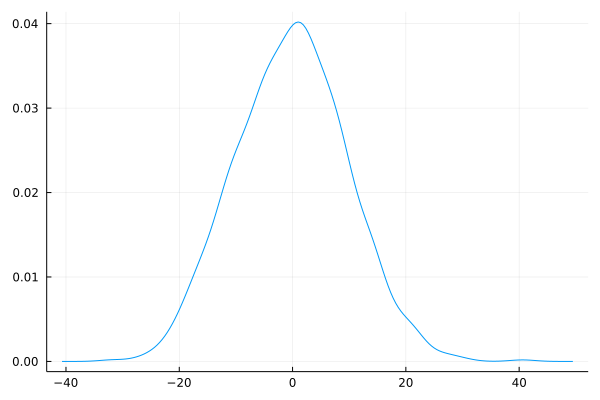

In [3]:
density(y)

## 4M2

In [4]:
@model function model_4m2(y)
    μ ~ Normal(0, 10)
    σ ~ Exponential(1)
    for i ∈ eachindex(y)
        y[i] ~ Normal(μ, σ)
    end
end

model_4m2 (generic function with 1 method)

## 4M3

```
σ ~ Exponential(1)
a ~ Uniform(0, 10)
b ~ Uniform(0, 1)
μᵢ = a + b⋅xᵢ
yᵢ ~ Normal(μ, σ)
```

## 4M4

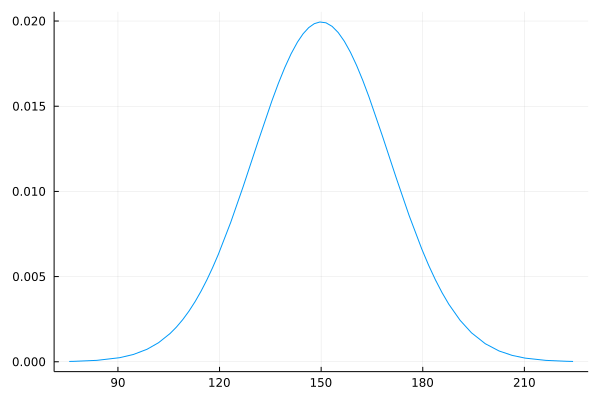

In [5]:
plot(Normal(150, 20))

Model

```
a ~ Normal(150, 20)
b ~ Uniform(-10, 10)
μ = a + b * year
σ ~ Exponential(1)
height ~ Normal(μ, σ)
```

## 4M5

I'd replace prior for b with `Uniform(0, 10)`

## 4M6

If variance is not larger than 64 cm, then we can decrease sigma in prior for a with `Normal(150, √64)`

## 4M7

In [6]:
d = DataFrame(CSV.File("../data/Howell1.csv"));
d2 = d[d.age .>= 18,:]

@model function height_regr_model(weight, height)
    a ~ Normal(178, 20)
    b ~ LogNormal(0, 1)
    μ = @. a + b * weight
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4_3 = sample(height_regr_model(d2.weight, d2.height), NUTS(0.65; init_ϵ=0.025), 1000)
m4_3 = resetrange(m4_3);

In [7]:
m4_3

Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 9.06 seconds
Compute duration  = 9.06 seconds
parameters        = a, b, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std   naive_se      mcse        ess      rhat    ⋯
      Symbol    Float64   Float64    Float64   Float64    Float64   Float64    ⋯

           a   114.4790    2.0234     0.0640    0.1088   371.7979    1.0042    ⋯
           b     0.8918    0.0443     0.0014    0.0024   372.5855    1.0044    ⋯
           σ     5.1080    0.2056     0.0065    0.0078   484.5477    1.0026    ⋯
                                                                1 column omitted

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%    

In [8]:
m4_3_df = DataFrame(m4_3)
precis(m4_3_df)

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std    5.5%      50%    94.5%       histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │ 114.479  2.0234  111.13  114.516  117.621    ▁▂▄▆▇██▆▄▁▁▁ │
│     b │  0.8918  0.0443  0.8241     0.89   0.9653  ▁▁▁▂▄▇██▇▆▄▃▂▁ │
│     σ │   5.108  0.2056  4.8056   5.0973   5.4482        ▁▂▇█▆▂▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


In [9]:
extrema(d2.weight)

(31.071052, 62.992589)

In [10]:
weight_seq = 25:70
μ = StatisticalRethinking.link(m4_3_df, [:a :b], weight_seq);
μ = hcat(μ...);

In [11]:
μ_mean = mean.(eachcol(μ))
μ_PI = percentile.(eachcol(μ), ([5.5, 94.5],))
μ_PI = vcat(μ_PI'...);

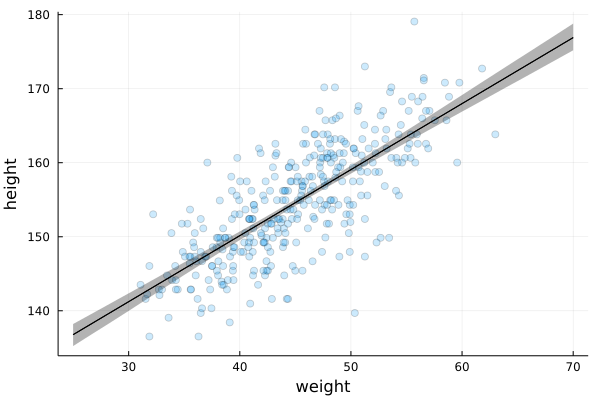

In [12]:
@df d2 scatter(:weight, :height; alpha=0.2, xlab="weight", ylab="height")
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3)

Conclusion: model is almost the same, but uncertainy on model's bias is higer

In [13]:
sim_height = simulate(m4_3_df, [:a, :b, :σ], weight_seq);

In [14]:
height_PI = percentile.(eachcol(sim_height), ([5.5, 94.5],))
height_PI = vcat(height_PI'...);

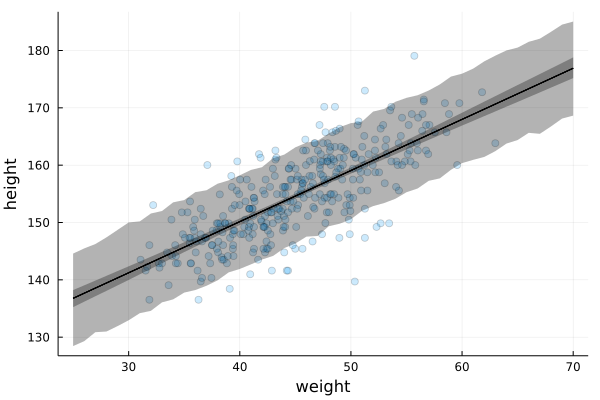

In [15]:
@df d2 scatter(:weight, :height; alpha=0.2, xlab="weight", ylab="height")
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3)
plot!(weight_seq, [μ_mean μ_mean]; c=:black, fillrange=height_PI, fillalpha=0.3)

## 4M8

In [16]:
d = DataFrame(CSV.File("../data/cherry_blossoms.csv", missingstring="NA"));
d2 = d[completecases(d[!,[:doy]]),:]
d2 = disallowmissing(d2[!,[:year,:doy]])

num_knots = 30

knots_list = quantile(d2.year, range(0, 1; length=num_knots))
basis = BSplineBasis(3, knots_list);

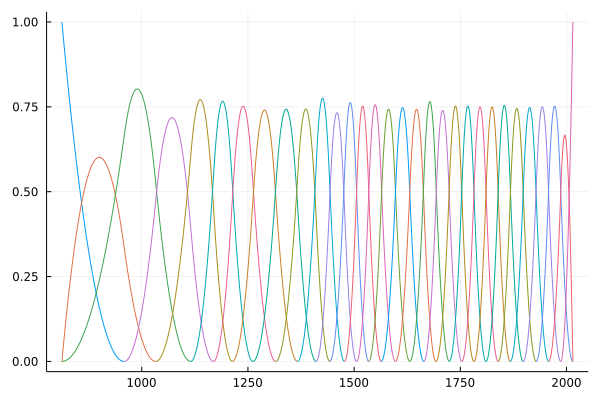

In [17]:
plot(basis; legend=false)

In [18]:
@model function model_splines(year, doy)
    w ~ MvNormal(zeros(length(basis)), 1)
    a ~ Normal(100, 10)
    s = Spline(basis, w)
    μ = a .+ s.(year)
    σ ~ Exponential(1)
    doy ~ MvNormal(μ, σ)
end

m4_7 = sample(model_splines(d2.year, d2.doy), NUTS(0.65), 1000)

Chains MCMC chain (1000×45×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 17.46 seconds
Compute duration  = 17.46 seconds
parameters        = w[1], w[30], w[21], w[17], w[29], w[13], w[25], σ, w[3], w[12], w[8], w[10], w[14], w[22], w[11], w[9], w[20], w[24], w[18], w[26], w[16], a, w[2], w[4], w[19], w[27], w[6], w[23], w[5], w[28], w[7], w[15], w[31]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

        w[1]   -0.4975    0.8871     0.0281    0.0129   2476.1758    0.9990    ⋯
        w[2]   -0.7785    0.8474     0.0268    0.0175   1805.6435    0.9992    ⋯
        w[3]   -0.6174

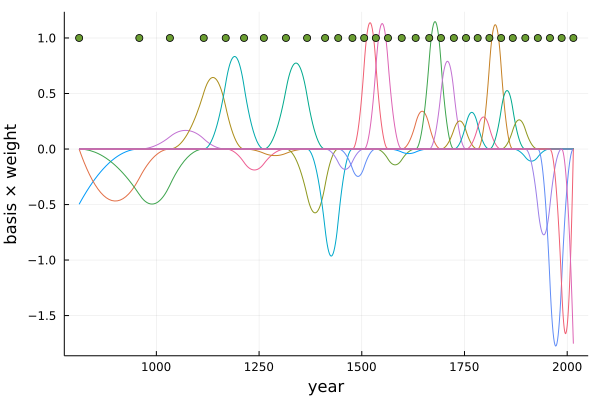

In [19]:
post = DataFrame(m4_7)

# convert columns w[*] into single column w
w_df = DataFrames.select(post, r"w")
post = DataFrames.select(post, Not(r"w"))
post[!,:w] = Vector.(eachrow(w_df))

# vector of 16 average w values
w_mean = mean.(eachcol(w_df))
p2 = plot(basis .* w_mean)
scatter!(knots_list, repeat([1], num_knots); xlab="year", ylab="basis × weight")

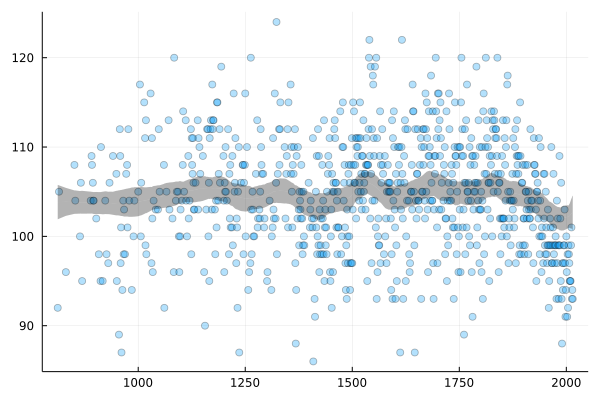

In [20]:
# explicit link logic
μ = [
    row.a .+ Spline(basis, row.w).(d2.year)
    for row ∈ eachrow(post)
]
μ = hcat(μ...);

μ_PI = percentile.(eachrow(μ), ([1.5, 98.5],))
μ_PI = vcat(μ_PI'...);

p3 = @df d2 scatter(:year, :doy; alpha=0.3)
μ_mean = mean.(eachrow(μ_PI))
plot!(d2.year, [μ_mean, μ_mean]; c=:black, fillrange=μ_PI, fillalpha=0.3, alpha=0)

Conclusion: more flexibility lead to more curvy spline fitted. Not very surprising :)

# Hard problems

## 4H1

In [21]:
d = DataFrame(CSV.File("../data/Howell1.csv"))
weight_norm = fit(ZScoreTransform, d.weight)
d[!, :weight_s] = StatsBase.transform(weight_norm, d.weight);

In [22]:
@model function model_4h1(weight_s, height)
    a ~ Normal(178, 20)
    b1 ~ LogNormal(0, 1)
    b2 ~ Normal(0, 1)
    μ = @. a + b1 * weight_s + b2 * weight_s^2
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4h1 = sample(model_4h1(d.weight_s, d.height), NUTS(), 1000)
m4h1_df = DataFrame(m4h1)
precis(m4h1_df)

┌───────┬─────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%        histogram │
├───────┼─────────────────────────────────────────────────────────────┤
│     a │ 146.045  0.3795  145.446  146.039  146.657    ▁▁▂▃▆▇█▆▅▂▁▁▁ │
│    b1 │ 21.7448  0.2862  21.2963  21.7435  22.1787      ▁▁▁▃▇██▅▂▁▁ │
│    b2 │ -7.7911  0.2755  -8.2286  -7.7886  -7.3468        ▁▁▂▅██▆▃▁ │
│     σ │  5.7913  0.1851   5.5176   5.7762   6.0954  ▁▁▁▂▄▇█▇▆▃▂▁▁▁▁ │
└───────┴─────────────────────────────────────────────────────────────┘


In [23]:
coefs = mapcols(mean, m4h1_df)[1,:]

,a,b1,b2,σ
,Float64,Float64,Float64,Float64
1,146.045,21.7448,-7.79113,5.79129


In [24]:
weights = [46.95, 43.72, 64.78, 32.59, 54.63]
norm_weights = StatsBase.transform(weight_norm, weights);

In [25]:
for (idx, w) ∈ enumerate(norm_weights)
    μ = coefs.a + coefs.b1 * w + coefs.b2 * w^2
    σ = coefs.σ
    data = rand(Normal(μ, σ), 1000)
    data_PI = PI(data)
    println("$idx: μ = $μ, PI = $data_PI")
end

1: μ = 158.17297554318768, PI = [149.20061178516175, 167.29000521717163]
2: μ = 155.6603139851321, PI = [146.2967592477171, 164.56201503190806]
3: μ = 158.53978848022172, PI = [149.54259508021758, 167.3338456080465]
4: μ = 141.25458413318688, PI = [132.19679645319556, 149.98992122490608]
5: μ = 161.13421514284394, PI = [151.97549580946543, 170.4313281659319]


## 4H2

In [26]:
d = DataFrame(CSV.File("../data/Howell1.csv"))
d = d[d.age .< 18,:]
xbar = mean(d.weight)

18.414193058854163

In [27]:
@model function model_4h2(weight, height)
    a ~ Normal(178, 20)
    b ~ LogNormal(0, 1)
    μ = @. a + b * (weight - xbar)
    σ ~ Uniform(0, 50)
    height ~ MvNormal(μ, σ)
end

m4h2 = sample(model_4h2(d.weight, d.height), NUTS(), 1000)
m4h2_df = DataFrame(m4h2)
precis(m4h2_df)

┌───────┬─────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%    histogram │
├───────┼─────────────────────────────────────────────────────────┤
│     a │ 108.383  0.6541  107.308  108.405  109.402    ▁▁▃▆██▅▂▁ │
│     b │  2.7145  0.0676   2.6047   2.7141   2.8204  ▁▁▁▄▆█▅▂▁▁▁ │
│     σ │  8.5456  0.4319   7.9085   8.5215    9.295     ▁▂██▃▁▁▁ │
└───────┴─────────────────────────────────────────────────────────┘


In [28]:
coefs = mapcols(mean, m4h2_df)[1,:]

,a,b,σ
,Float64,Float64,Float64
1,108.384,2.71452,8.54561


In [29]:
v = coefs.b*10
println("Every 10 units of weigth increase we expect the height to increase $(round(v, digits=2))")

Every 10 units of weigth increase we expect the height to increase 27.15


In [30]:
w_seq = range(extrema(d.weight)...; length=30)

μ = StatisticalRethinking.link(m4h2_df, [:a, :b], w_seq, xbar)
μ = hcat(μ...)
μ_mean = mean.(eachcol(μ))
μ_PI = PI.(eachcol(μ))
μ_PI = vcat(μ_PI'...);

sim_height = simulate(m4h2_df, [:a, :b, :σ], w_seq .- xbar)
sim_PI = PI.(eachcol(sim_height))
sim_PI = vcat(sim_PI'...);

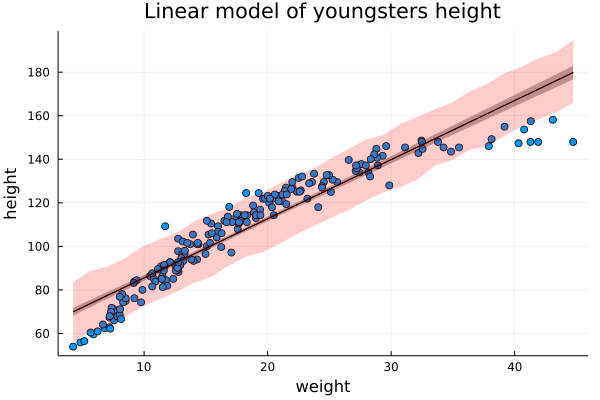

In [31]:
scatter(d.weight, d.height; xlab="weight", ylab="height", title="Linear model of youngsters height")
plot!(w_seq, [μ_mean μ_mean]; fillrange=μ_PI, color=:black, fillalpha=0.3)
plot!(w_seq, [μ_mean μ_mean]; lw=0, fillrange=sim_PI, color=:red, fillalpha=0.2)

Concerns: linear model just doing too much oversimplification. Boundaries (too light and too heavy) are not linear scale.